In [1]:
# pip install 'gym[atari]'
# pip install 'stable-baselines3[extra]'

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from stable_baselines3.common.cmd_util import make_atari_env
import pybullet_envs
# from stable_baselines3.common.policies import CnnPolicy
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/stable_baselines3/common/cmd_util.py:5: FutureWarning: Module ``common.cmd_util`` has been renamed to ``common.env_util`` and will be removed in the future.
  warnings.warn(


In [4]:
pybullet_envs.getList()

['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

In [5]:
def get_env(n_envs=16):
    # There already exists an environment generator that will make and wrap atari environments correctly.
    # We use 16 parallel processes
    env = make_vec_env('HalfCheetahBulletEnv-v0', n_envs=n_envs, seed=0)
    # Stack 4 frames
    env = VecFrameStack(env, n_stack=4)
    return env

In [6]:
env = get_env(1)

/Users/julian/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


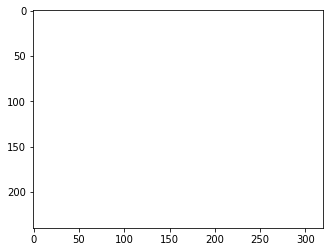

In [7]:
state = env.render(mode='rgb_array')
plt.imshow(state)

In [10]:
from typing import Any, Dict

import gym
import torch as th

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import Video


class VideoRecorderCallback(BaseCallback):
    def __init__(self, eval_env: gym.Env, render_freq: int, n_eval_episodes: int = 1, deterministic: bool = True):
        """
        Records a video of an agent's trajectory traversing ``eval_env`` and logs it to TensorBoard

        :param eval_env: A gym environment from which the trajectory is recorded
        :param render_freq: Render the agent's trajectory every eval_freq call of the callback.
        :param n_eval_episodes: Number of episodes to render
        :param deterministic: Whether to use deterministic or stochastic policy
        """
        super().__init__()
        self._eval_env = eval_env
        self._render_freq = render_freq
        self._n_eval_episodes = n_eval_episodes
        self._deterministic = deterministic

    def _on_step(self) -> bool:
        if self.n_calls % self._render_freq == 0:
            screens = []

            def grab_screens(_locals: Dict[str, Any], _globals: Dict[str, Any]) -> None:
                """
                Renders the environment in its current state, recording the screen in the captured `screens` list

                :param _locals: A dictionary containing all local variables of the callback's scope
                :param _globals: A dictionary containing all global variables of the callback's scope
                """
                screen = self._eval_env.render(mode="rgb_array")
                # PyTorch uses CxHxW vs HxWxC gym (and tensorflow) image convention
                screens.append(screen.transpose(2, 0, 1))

            evaluate_policy(
                self.model,
                self._eval_env,
                callback=grab_screens,
                n_eval_episodes=self._n_eval_episodes,
                deterministic=self._deterministic,
            )
            self.logger.record(
                f"trajectory/video_{self.n_calls}",
                Video(th.ByteTensor([screens]), fps=40),
                exclude=("stdout", "log", "json", "csv"),
            )
        return True

In [12]:
env = get_env()

In [13]:
model = A2C('MlpPolicy', env, verbose=1, tensorboard_log="./a2c_cheeta_tensorboard/")

Using cpu device


In [ ]:
video_recorder = VideoRecorderCallback(get_env(n_envs=1), render_freq=5000)
model.learn(total_timesteps=int(5e6), callback=video_recorder)

Logging to ./a2c_cheeta_tensorboard/A2C_1
------------------------------------
| time/                 |          |
|    fps                | 1311     |
|    iterations         | 100      |
|    time_elapsed       | 6        |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -8.45    |
|    explained_variance | -0.00222 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -17.8    |
|    std                | 0.989    |
|    value_loss         | 9.89     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1e+03    |
|    ep_rew_mean        | -865     |
| time/                 |          |
|    fps                | 1320     |
|    iterations         | 200      |
|    time_elapsed       | 12       |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -8.43  

In [ ]:
obs = env.reset()
while True:
    # By default, deterministic=False, so we use the stochastic policy
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()